## Bi-LSTM with synonym augmentation

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('data_files/abortion/sentences2.pkl', 'rb') as f:
    sentences = pickle.load(f)
prol = sentences[0]
proc = sentences[1]

## data augmentation via synonym substitution

### nltk synonyms

In [3]:
import nltk
from nltk.corpus import wordnet as wn

concerns = {'NN': wn.NOUN,'JJ':wn.ADJ,'VB':wn.VERB,'RB':wn.ADV}


import numpy as np

def synonimize(word, pos=None):
    """ Get synonyms of the word / lemma """ 
    try:
        # map part of speech tags to wordnet
#        pos = {'NN': wn.NOUN,'JJ':wn.ADJ,'VB':wn.VERB,'RB':wn.ADV}[pos[:2]]
        pos = {'NN': wn.NOUN,'JJ':wn.ADJ}[pos[:2]]
    except:
        # or just return the original word
#        print(word)
        return [word]
    
    
    synsets = wn.synsets(word)#, pos)
    synonyms = []
    for synset in synsets:
        names = synset.lemma_names()
        for sim in  names:
            synonyms.append(sim)
    
    # return list of synonyms or just the original word
    return synonyms or [word]

def vary_sentence(sentence):
    """ Create variations of a sentence using synonyms """
    words = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(words)

    words = []
    for (word, pos) in pos_tags:
        synonyms = synonimize(word, pos)
        picked = np.random.choice(synonyms)
     
        words.append(picked)

    return " ".join(words)

def vary_by_noun(sentence):
    """ Create variations of a sentence using synonyms """
    words = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(words)

    words = []
    for (word, pos) in pos_tags:
        if pos[:2] == 'NN':
            synonyms = synonimize(word, pos)
            picked = np.random.choice(synonyms)
            words.append(picked)
        else:
            words.append(word)

    return " ".join(words)

def vary_by_adjective(sentence):
    words = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(words)

    words = []
    for (word, pos) in pos_tags:
        if pos[:2] == 'JJ':
            synonyms = synonimize(word, pos)
            picked = np.random.choice(synonyms)
            words.append(picked)
        else:
            words.append(word)

    return " ".join(words)

def vary_by_noun_or_adj(sentence, noun_prob=0.5):
    if np.random.random() < noun_prob:
        return vary_by_noun(sentence)
    else:
        return vary_by_adjective(sentence)

In [4]:
# redo = False
# if redo:
#     n_syns=2
#     print(len(prol),len(proc))
#     for k in range(n_syns):
#         prol = [[str(k)]+[str(vary_sentence(k))] for k in prol]
#         proc = [[str(k)]+[str(vary_sentence(k))] for k in proc]
#         import itertools
#         prol = list(itertools.chain(*prol))
#         proc = list(itertools.chain(*proc))
#         print(len(prol),len(proc))
#         with open('data_files/abortion/sentences_syn2.pkl', 'wb') as f:
#             pickle.dump([prol,proc], f)

# else:
#     [prol,proc] = pickle.load('data_files/abortion/sentences_syn2.pkl')


In [5]:
# print(len(prol),len(proc))
# with open('data_files/abortion/sentences_syn2.pkl', 'wb') as f:
#     pickle.dump([prol,proc], f)

In [4]:
print(len(prol),len(proc))
prol = [p for p in prol if p]
proc = [p for p in proc if p]
prol = [p for p in prol if p[0]!=">"]
proc = [p for p in proc if p[0]!=">"]

# combine two sentences
prol = [str(prol[k:k+1][0])+str(prol[k+1:k+2]) for k in range(len(prol))]
proc = [str(proc[k:k+1][0])+str(proc[k+1:k+2]) for k in range(len(proc))]
print(len(prol),len(proc))

52968 48124
41505 39306


In [33]:
# # num_words we use
# num_words = 50000

# # if we want two-sentence input# prolife is zero prochoice is 1

# X = prol + proc
# print(len(X))
# print("num sentences total: ", len(X), "using {} words".format(num_words))


# # prolife is zero prochoice is 1
# Y = np.hstack((np.zeros(shape=len(prol)), np.ones(shape=len(proc))))

# # split data into train and test set, and shuffle it
# idx_train, idx_test, y_train, y_test = train_test_split(
#                 np.array([range(len(Y))]).T, Y, test_size=0.2, random_state=0)
# idx_train = np.array(idx_train.T[0],dtype='int')
# idx_test = idx_test.T[0]

In [5]:
from sklearn.model_selection import train_test_split
import keras
num_words = 50000

# no info leak here
X = prol + proc
Y = np.hstack((np.zeros(shape=len(prol)), np.ones(shape=len(proc))))

# split data into train and test set, and shuffle it
idx_train, idx_test, y_train, y_test = train_test_split(
                np.array([range(len(Y))]).T, Y, test_size=0.2, random_state=0)
idx_train = np.array(idx_train.T[0],dtype='int')
idx_test = idx_test.T[0]

X_train = [X[k] for k in idx_train]
X_test = [X[k] for k in idx_test]

/Users/yuki/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
print(len(X_train))
X_train = [[str(k)]+[str(vary_by_noun_or_adj(str(k),0.2).replace("_"," "))] +
           [str(vary_by_noun_or_adj(str(k),0.2).replace("_"," "))] for k in X_train]
import itertools
X_train = list(itertools.chain(*X_train))
print(len(X_train))

y_train = np.column_stack((y_train, y_train,y_train)).flatten()

64648
193944


In [8]:
with open('data_files/abortion/Xtrain3_ytrain3_02.pkl', 'wb') as f:
     pickle.dump([X_train,y_train], f)

### prep for keras

In [9]:
# changes words to numbers
# tokenizing based on train data (i.e. will see new words in testset)
tokenizer = keras.preprocessing.text.Tokenizer(num_words=num_words, lower=True,
                                                filters='!""#$%&()*+,-./:;<=>?@[\]^_`{|}~ ”][',
                                               split=" ",oov_token=0)


tokenizer.fit_on_texts(X_train)
#X2 = np.array(tokenizer.texts_to_sequences([X[k] for k in range(len(X))]))
print(X_train[95])
x_train = np.array(tokenizer.texts_to_sequences(X_train))
x_test = np.array(tokenizer.texts_to_sequences(X_test))
print(x_train[95])

I get where this is going and what the idea is , but I definitely still have trauma from my decision to have an abortion [ ' I was married and pregnant ' ]
[9, 74, 120, 27, 7, 143, 6, 36, 1, 375, 7, 22, 9, 602, 119, 18, 1669, 55, 45, 370, 3, 18, 31, 24, 2, 9, 40, 940, 6, 128, 2]


In [11]:
print(X_train[912])
print(x_train[912])

 I'm not aware of a ton of new research coming out in that window of time to support your statement["I didn't realize this--it's very disturbing if true"]
[184, 13, 756, 5, 4, 1220, 5, 292, 763, 931, 73, 12, 8, 3117, 5, 117, 3, 156, 38, 520, 9, 600, 751, 27, 112, 109, 3776, 20, 339]


In [ ]:
# embeddings_index = {}
# maxlen = 100
# EMBEDDING_DIM = 100

# word_index = tokenizer.word_index
# print('Found %s unique tokens.' % len(word_index))

# import os
# f = open(os.path.join('','glove.6B.100d.txt'))
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()



# from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,CuDNNLSTM

# embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector

# embedding_layer = Embedding(len(word_index) + 1,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=maxlen,
#                             trainable=False)

0.9626799488512148


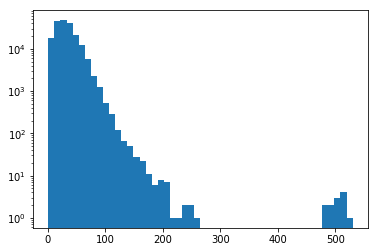

In [12]:
L = [len(x) for x in x_train]
_ = plt.hist(L,  bins=50,log=True)
print(np.sum(np.array(L)<70) / len(L))

## train model

In [13]:
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM,GRU, Bidirectional,CuDNNLSTM
from keras.datasets import imdb


# cut texts after this number of words
# (among top max_features most common words)
batch_size = 32


maxlen = 70
print('Loading data...')
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print('removing len zero and len1 sentences...')

nonzero1 = x_train.sum(1)>1
x_train = x_train[nonzero1]
y_train = y_train[nonzero1]

print(len(x_train))
nonzero2 = x_test.sum(1)>1
x_test = x_test[nonzero2]
y_test = y_test[nonzero2]
print(len(x_test))

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)


model = Sequential()
model.add(Embedding(num_words, 50, input_length=maxlen))
model.add(Bidirectional(GRU(30)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=50,shuffle=True,
          validation_data=[x_test, y_test])

Loading data...
193944 train sequences
16163 test sequences
Pad sequences (samples x time)
removing len zero and len1 sentences...
193944
16163
x_train shape: (193944, 70)
x_test shape: (16163, 70)
Train...
Train on 193944 samples, validate on 16163 samples
Epoch 1/50
193944/193944 [==============================] - 483s 2ms/step - loss: 0.5628 - acc: 0.6994 - val_loss: 0.5565 - val_acc: 0.7117
Epoch 2/50
193944/193944 [==============================] - 498s 3ms/step - loss: 0.3954 - acc: 0.8138 - val_loss: 0.6121 - val_acc: 0.7221
Epoch 3/50
193944/193944 [==============================] - 478s 2ms/step - loss: 0.2907 - acc: 0.8662 - val_loss: 0.6134 - val_acc: 0.7468
Epoch 4/50
193944/193944 [==============================] - 478s 2ms/step - loss: 0.2102 - acc: 0.9077 - val_loss: 0.6682 - val_acc: 0.7537
Epoch 5/50
193944/193944 [==============================] - 726s 4ms/step - loss: 0.1486 - acc: 0.9376 - val_loss: 0.7740 - val_acc: 0.7629
Epoch 6/50
193944/193944 [================

KeyboardInterrupt: 

In [ ]:
example= ['I believe women should be able to choose their own fate they should not be restrained']
# prolife is zero prochoice is 1
ex = tokenizer.texts_to_sequences(example)
ex = np.array(sequence.pad_sequences(ex, maxlen=maxlen))
print(ex.shape)
print(model.predict(ex))

In [ ]:
example = ['abortion is wrong It should be made illegal']
ex = tokenizer.texts_to_sequences(example)
ex = np.array(sequence.pad_sequences(ex, maxlen=maxlen))
print(model.predict(ex))

## save model and tokenizer

In [14]:
model.save('data_files/abortion/bilstm_syn3_02.h5')

In [15]:
import pickle

# saving
with open('data_files/abortion/tokenizer_syn3_02.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)